In [1]:
from google.colab import files
uploaded = files.upload()

Saving DataSet.rar to DataSet.rar


In [2]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
!unrar x DataSet.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from DataSet.rar

Creating    DataSet                                                   OK
Creating    DataSet/Data_cloudy                                       OK
Extracting  DataSet/Data_cloudy/train_10021.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10070.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10096.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_101.jpg                              0%  OK 
Extracting  DataSet/Data_cloudy/train_10128.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10177.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10231.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10451.jpg                            0%  OK 
Extracting  D

In [4]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder('/content/DataSet', transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [6]:
vgg = models.vgg19(pretrained=True)
for param in vgg.features.parameters():
    param.requires_grad = False

vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, num_classes)
vgg.to(device)

optimizer = optim.Adam(vgg.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 89.3MB/s]


In [7]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for epoch in range(epochs):
        model.train()
        correct, total, train_loss = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        train_acc = correct / total

        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()
                _, preds = torch.max(out, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        val_acc = correct / total

        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    return history

In [8]:
history_vgg = train_model(vgg, criterion, optimizer, train_loader, val_loader)

Epoch 1: Train Acc=0.8762, Val Acc=0.9630
Epoch 2: Train Acc=0.9817, Val Acc=0.9852
Epoch 3: Train Acc=0.9897, Val Acc=0.9926
Epoch 4: Train Acc=0.9952, Val Acc=0.9926
Epoch 5: Train Acc=0.9968, Val Acc=0.9889


                 precision    recall  f1-score   support

    Data_cloudy       1.00      1.00      1.00        86
    Data_desert       1.00      1.00      1.00        66
Data_green_area       0.97      0.99      0.98        73
     Data_water       0.98      0.96      0.97        45

       accuracy                           0.99       270
      macro avg       0.99      0.99      0.99       270
   weighted avg       0.99      0.99      0.99       270



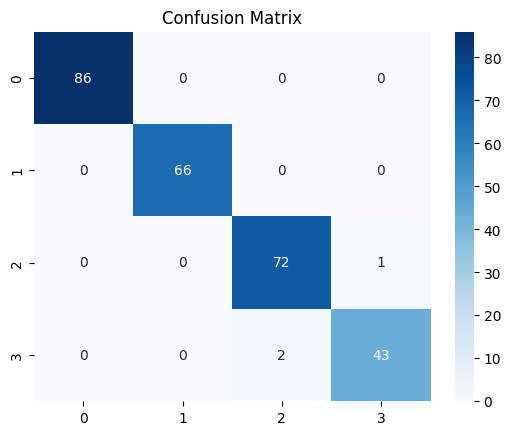

In [9]:
def evaluate(model):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            out = model(x)
            _, preds = torch.max(out, 1)
            y_true.extend(y.numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

evaluate(vgg)